In [1]:
import numpy as np
import pandas as pd
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy.special import iv
from scipy.optimize import curve_fit

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

deriv_dir = os.path.expanduser("../derivatives")
dataframes_dir = os.path.join(deriv_dir, "dataframes")

subjects = [114, 115, 127, 135, 136, 139, 141, 142]
rois = ['V1', 'V2', 'V3', 'V4', 'LO1', 'V3ab', 'IPS0']
tasks = ['perception', 'wm', 'ltm']

task_cmap = {
    'perception': 'darkblue',
    'wm': 'green',
    'ltm': 'orange'
}
roi_label_loc = {roi:rois.index(roi) for roi in rois}

scatter_dot_size = 4
fig_height = 5
fig_width = 5

rois = ["V1", 'V2', 'V3', 'V4', 'LO1', 'V3ab', 'IPS0']
tasks = ['perception', 'wm', 'ltm']
metrics = ['loc_deg', 'amp', 'fwhm']

plt.style.use('seaborn-v0_8')

# Fig 7a.

/var/folders/2h/28f74q2d14b9k1nvsyvnn064_091rw/T/ipykernel_49359/730380681.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels([-7, 0, 7])
/var/folders/2h/28f74q2d14b9k1nvsyvnn064_091rw/T/ipykernel_49359/730380681.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([-7, 0, 7])
/var/folders/2h/28f74q2d14b9k1nvsyvnn064_091rw/T/ipykernel_49359/730380681.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([-7, 0, 7])
/var/folders/2h/28f74q2d14b9k1nvsyvnn064_091rw/T/ipykernel_49359/730380681.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([-7, 0, 7])


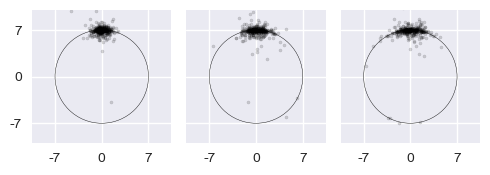

In [2]:
from matplotlib.patches import Circle
from scipy.stats import vonmises
import scipy.signal as sp

wlsubjects = [114, 115, 127, 135, 136, 139, 141, 142]
rois = ["V1", "V2", "V3", "V4", "LO1", "V3ab", "IPS0"]

# Set path to dataframe directory

fname = os.path.join(dataframes_dir, "saccades",'sub-all_saccades.tsv')
Saccades = pd.read_csv(fname, sep = '\t', index_col = 0)
tasks = ['perception', 'wm', 'ltm']

query_str = "task==@task & sacc_label=='response' & wlsubj != 139"

fig,axs = plt.subplots(1, 3, figsize = [fig_width, fig_height/2.7], sharey = True)
colors = {
    'perception':'teal',
    'ltm':'orange',
    'wm':'green'
}

sz = 35

target_ring = Circle((0, 0), radius = 7, fill = False)

for i, g in enumerate(Saccades.groupby('task', as_index=False)):
    task, s = g
    s = s.query(query_str)
    i = tasks.index(task)
    axs[i].scatter(s.x_centered, s.y_centered, c = 'black', alpha = 0.15, s = 5)

    target_ring = Circle((0, 0), radius = 7, fill = False)
    axs[i].set_yticklabels([-7, 0, 7])
    axs[i].set_yticks([-7, 0, 7])
    axs[i].set_xticklabels([-7, 0, 7])
    axs[i].set_xticks([-7, 0, 7])
    axs[i].add_patch(target_ring)

    axs[i].axis('equal')
    axs[i].set_xlim([-10, 10])
    axs[i].set_ylim([-10, 10])

fig.tight_layout()
plt.savefig(os.path.join("fig_images", "fig7A.pdf") , transparent = False)

# Fig 7b

('perception', 'clock')
('perception', 'counter')
('perception', 'center')
('wm', 'clock')
('wm', 'counter')
('wm', 'center')
('ltm', 'clock')
('ltm', 'counter')
('ltm', 'center')


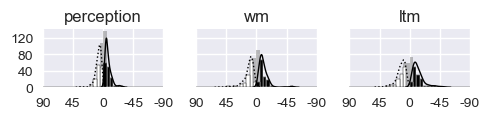

In [3]:
t_fname = os.path.join(dataframes_dir, "saccades", "trialwise_saccades.tsv")

T = pd.read_csv(t_fname, sep = '\t', index_col = 0)

fig, axs = plt.subplots(1, 3, figsize = [fig_width, 1.3], sharey=True)
query = "ang_dist > -56 & ang_dist < 56 & subj != 139 & task == @task & tertile == @key"
bottom = []
for i, g in enumerate(itertools.product(tasks, T.tertile.unique())):
    task, key = g
    print(g)

    s = T.query(query)

    if key =='counter':
        s=s.query("ang_dist < 1")
    elif key == 'clock':
        s=s.query("ang_dist > 1")

    angdist = -s.ang_dist

    i = tasks.index(task)
    ax2 = axs[i].twinx()  
    ax1 = axs[i]


    k, l, sc = vonmises.fit(np.radians(angdist), fscale=1)
    vm = vonmises.pdf(np.linspace(-np.pi, np.pi, 360), loc=l, kappa=k, scale=sc)
    fwhm, _, _, _ = sp.peak_widths(
            vm, np.where(vm == vm.max())[0])

    match key:
        case "counter": 
            ls = ":"
            B = ax1.hist(np.radians(angdist), bins = np.arange(-np.pi, np.pi, np.radians(5)),
                    alpha = 1, color = 'white', edgecolor = 'black', bottom = bottom) 
            sns.kdeplot(np.radians(angdist), ax = ax2, color = 'black', linewidth = 1, linestyle = ls, bw_method = 0.4)        
            bottom += B[0]
            
        case "clock": 
            ls = "-"
            B = ax1.hist(np.radians(angdist), bins = np.arange(-np.pi, np.pi, np.radians(5)),
                    alpha = 1, color = 'black', edgecolor = 'white')
            sns.kdeplot(np.radians(angdist), ax = ax2, color = 'black', linewidth = 1, linestyle = ls, bw_method = 0.4) 
            bottom = B[0]
        case "center": 
            ls = "-"
            ax1.hist(np.radians(angdist), bins = np.arange(-np.pi, np.pi, np.radians(5)),
                    alpha = 0.5, color = 'gray', bottom = bottom)

    ax2.set_xlim([-np.radians(90), np.radians(90)])
    ax2.set_ylim([0, 8])
    ax1.set_ylim([0, 140])
    ax1.set_title(task)

    xlocs = np.asarray([-np.pi/2, -np.pi/4, 0 , np.pi/4, np.pi/2])
    xlabels = np.degrees(xlocs).astype(int)
    ax1.set_xticks(xlocs)
    ax1.set_xticklabels(xlabels)
    ax1.set_yticks(np.arange(0, 121, 40))
    ax1.set_yticklabels(np.arange(0, 121, 40))

    ax2.set_yticks([])
    ax2.set_ylabel("")

    ax1.invert_xaxis()
   
fig.tight_layout()
plt.savefig(os.path.join("fig_images", "fig7B.pdf") , transparent = False)

# Fig 7C

In [4]:
fname = os.path.join(dataframes_dir, "glmsingle/allsubj_vmfits_ang_dist_bin_saccsplit.tsv")
saccsplit = pd.read_csv(fname, sep = '\t', index_col = 0)
saccsplit.insert(len(saccsplit.columns), 'roi_labels_loc', saccsplit.roi_labels.map(roi_label_loc).values)

# Load bootstraps
path_pattern = os.path.join(dataframes_dir, "glmsingle/bootstrap_vmfits_saccsplit/allsubj_vmfits_ang_dist_bin__saccsplit_batch_%d.tsv")
boot_df = []
for i in range(1, 21):
    fname = path_pattern % i
    data = pd.read_csv(fname, sep = '\t', index_col = 0)
    data.insert(0, 'batch_num', i)
    boot_df.append(data)
    
boot_df = pd.concat(boot_df)
boot_df['roi_labels'] = pd.Categorical(boot_df['roi_labels'], categories = rois , ordered = True)

In [5]:
tasks = ['perception', 'wm', 'ltm']
# Get CIs for all-roi group
all_roi_boot = boot_df.groupby(['task', 'tertile', 'batch_num', 'n_boot'], as_index = False).mean().query("tertile != 'center'")
data_df_all = []
for task, tertile, metric in itertools.product(tasks, ['counter', 'clock'], metrics + ["loc"]):
    data = all_roi_boot.query("task == @task & tertile == @tertile")

    CIs = np.nanquantile(data[metric], [0.16, 0.84, 0.025, 0.975])
    metric_val = saccsplit.query("task == @task & tertile == @tertile").groupby(['task', 'tertile'], as_index=False).mean()[metric].values[0]

    row = [task, tertile, metric, metric_val, *CIs]
    data_df_all.append(row)

data_df_all = pd.DataFrame(data_df_all, columns = ["task", "tertile", "metric", "value", "lower_68_CI", "upper_68_CI", "lower_95_CI", "upper_95_CI"])

# Get CIs for each roi 
data_df = []
for roi, task, tertile, metric in itertools.product(rois, tasks, ['counter', 'clock'], metrics + ["loc"]):
    data = boot_df.query("task == @task & roi_labels == @roi & tertile == @tertile")

    m = [i for i in data[metric] if i != np.nan]
    CIs = np.nanquantile(m, [0.16, 0.84, 0.025, 0.975])
    metric_val = saccsplit.query("task == @task & roi_labels == @roi & tertile == @tertile")[metric].values[0]

    row = [roi, task, tertile, metric, metric_val, *CIs]
    data_df.append(row)

data_df = pd.DataFrame(data_df, columns = ['roi_labels', "task", "tertile", "metric", "value", "lower_68_CI", "upper_68_CI", "lower_95_CI", "upper_95_CI"])


/var/folders/2h/28f74q2d14b9k1nvsyvnn064_091rw/T/ipykernel_49359/2513687488.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_roi_boot = boot_df.groupby(['task', 'tertile', 'batch_num', 'n_boot'], as_index = False).mean().query("tertile != 'center'")
/var/folders/2h/28f74q2d14b9k1nvsyvnn064_091rw/T/ipykernel_49359/2513687488.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  metric_val = saccsplit.query("task == @task & tertile == @tertile").groupby(['task', 'tertile'], as_index=False).mean()[metric].values[0]
/var/folders/2h/28f74q2d14b9k1nvsyvnn064_091rw/T/ipykernel_49359/2513687488.py:9: FutureWar

/var/folders/2h/28f74q2d14b9k1nvsyvnn064_091rw/T/ipykernel_49359/517555149.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_roi = saccsplit.groupby(['task', 'tertile'], as_index = False).mean()


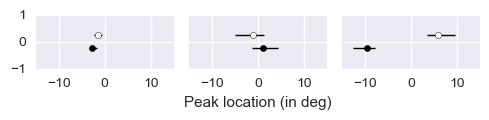

In [6]:
all_roi = saccsplit.groupby(['task', 'tertile'], as_index = False).mean()
all_roi = all_roi.query("tertile != 'center'")

plt.style.use('seaborn-v0_8')
fig, axs = plt.subplots(1, 3, figsize = [fig_width, 1.3], sharey = True , sharex = True)
for task, tertile in itertools.product(tasks, ['clock', 'counter']):
    ax = axs[tasks.index(task)]

    b = data_df_all.query("metric == 'loc_deg' & task == @task & tertile == @tertile")
    xerr = [b.value - b.lower_68_CI.values, b.upper_68_CI.values - b.value]
    xerr = np.asarray(xerr)
    xerr[xerr < 0] = 0

    if tertile == 'counter': 
        y = .25
    else:
        y = -.25

    ax.errorbar(b.value, y, xerr = xerr, fmt = "none", color = 'black', zorder=1, linewidth=1)

    ax.scatter(b.value, y, color = 'black',
               facecolor = b.tertile.map({'clock':'black', 'counter':'white'}), zorder=2, s = 20) 
    

    ax.set_xlim([-15, 15])
    ax.set_ylim([-1, 1])

axs[1].set_xlabel("Peak location (in deg)")


plt.gcf().tight_layout()
plt.savefig(os.path.join("fig_images", "fig7C.pdf") , transparent = False)

# Fig 7D

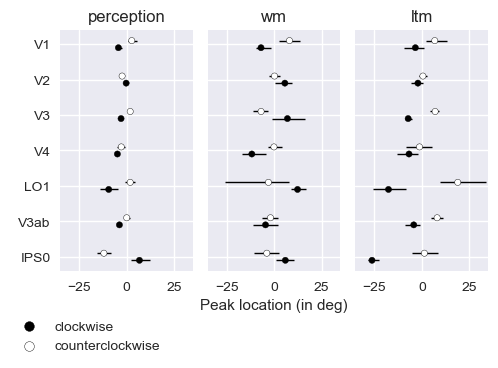

In [7]:
fig, axs = plt.subplots(1, 3, figsize = [fig_width, fig_height/1.5], sharey = True , sharex = True, layout = 'constrained')
for task, tertile in itertools.product(tasks, ["counter", "clock"]):

    ax = axs[tasks.index(task)]

    ax.invert_yaxis()
    ax.set_xlim([-35, 35])
    ax.set_title(task)

    b = data_df.query("metric == 'loc_deg' & task == @task & tertile == @tertile")
    xerr = [b.value - b.lower_68_CI.values, b.upper_68_CI.values - b.value]
    xerr = np.asarray(xerr)

    offset = ["counter", "clock"].index(tertile) * -.2
    y = [rois.index(label)+1 - offset for label in b.roi_labels]

    ax.errorbar(b.value, y, xerr = xerr, fmt = "none", color = 'black', zorder=1, linewidth = 1)

    ax.scatter(b.value, y, color = 'black', 
            facecolor = b.tertile.map({'clock':'black', 'counter':'white'}), s = 20, zorder = 2)

plt.scatter([],[], label = "clockwise", color = 'black', facecolor = 'black')

plt.scatter([],[], label = "counterclockwise", color = 'black', facecolor = 'white')

axs[1].set_xlabel("Peak location (in deg)")
ax.invert_yaxis()
fig.legend(loc = 'upper left', bbox_to_anchor = (0, 0.06), bbox_transform = fig.transFigure)

axs[0].set_yticks(np.arange(1, 8)+.1, rois)

plt.gcf().tight_layout()
plt.savefig(os.path.join("fig_images", "fig7D.pdf") , transparent = False)